# Numerical solution of nonlinear equations

Given a function $f:I \subseteq \mathbb{R} \to \mathbb{R}$, we are dealing with the problem of finding $\alpha\in\mathbb{R}$ such that $f(\alpha)=0$. 
Methods to solve this kind pf problems are generally iterative, generating a sequence of numbers $x^{(k)}$ that will hopefully converge to $\alpha$. 


In this exercise session we will focus on the following methods presented during the course:

1. Bisection method
2. Newton method
3. Chord method
4. Secant method
5. Fixed point iterations

In particular we will implement these methods and compare them by solving a given nonlinear equation.



In [1]:
from numpy import *

from matplotlib.pyplot import *
%matplotlib inline

In [2]:
import sympy as sym

t = sym.symbols('t')

f_sym = t/8. * (63.*t**4 - 70.*t**2. +15.) # Legendre polynomial of order 5
f_prime_sym = sym.diff(f_sym,t)

f = sym.lambdify(t, f_sym, 'numpy')
f_prime = sym.lambdify(t,f_prime_sym, 'numpy')


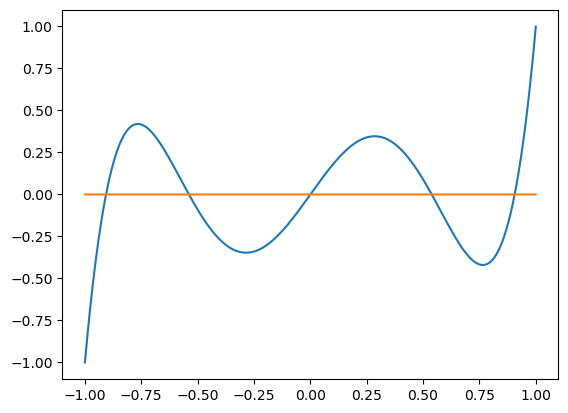

In [3]:
n = 1025
x = linspace(-1,1,n)
c = zeros_like(x)
_ = plot(x,f(x))
_ = plot(x,c)

To compare the algorithms, we start from the same initial point and with the same tollerances and stopping criteria. 

In [4]:
# Initial data for the various algorithms

# interval in which we seek the solution
a = 0.75
b = 1.

# initial points
x0 = (a+b)/2.0
x00 = b


In [5]:
# stopping criteria
eps = 1e-10
n_max = 1000

## Bisection method

This method is used to compute the roots a a _continous_ function $f:[a,b]\to\mathbb{R}$. 
Theorem of existence of zeroes for continuos functions states that if $f(a)f(b)<0$, then $f$ has at least one zero in $(a,b)$.
By iteratively bisecting the interval, we can generate a sequence of intervals of exponentially decreeing length $(a^{(k)},b^{(k)})$ such that, $\forall k$, $\alpha \in (a^{(k)},b^{(k)})$.

In [6]:
def bisect(f,a,b,eps,n_max):
	'''
	Implementation of the bisection method. 
	f function handle 
	a,b interval where we look for the root
	eps stopping criterion threshold
	n_max max number of iterations 
	'''
	
	# Check hypotheses
	assert f(a)*f(b)<0 

	# Initialization
	a_new = a
	b_new = b
	x = mean([a,b])

	err = 1+eps
	errors = [err]
	it = 0
	
	while (err > eps and it < n_max):

		if ( f(a_new) * f(x) < 0 ):
			# root in (a_new,x)
			b_new = x
		else:
			# root in (x,b_new)
			a_new = x

		x_new = mean([a_new,b_new])

		# Error can be computed in different ways:
		#err = 0.5 *(b_new -a_new)
		# err = abs(f(x_new))
		err = abs(x-x_new)

		# Save error for output 
		errors.append(err)

		# Update 
		x = x_new
		it += 1

	return x, it, errors

In [7]:
%time
[alpha, iters_bisect, errors_bisect] = bisect(f,a,b,eps,n_max)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


Bisection found root 0.9061798459733836 in 31 iterations.
Residual on approximate solution is 2.38535626354048e-10


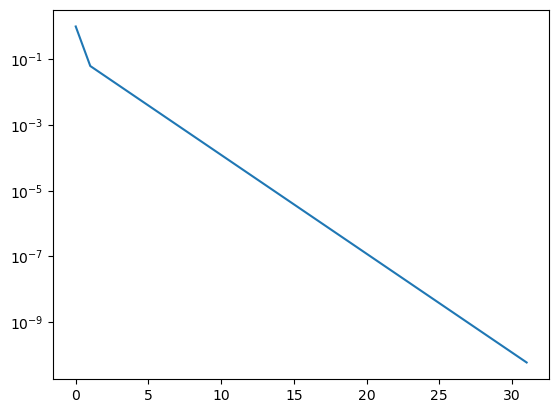

In [8]:
print("Bisection found root",alpha,"in",iters_bisect,"iterations.")
print("Residual on approximate solution is",abs(f(alpha)))


_=semilogy(errors_bisect)

### Theoretical number of iterations to reach target accuracy
At each iteration $k$ of the bisection method we have the zero $\alpha\in (a^{(k)},b^{(k)})$; we can therefore explicitly estimate the error at each step:
$$ e^{(k)} := \vert x^{(k)} - \alpha \vert \leq \frac{b^{(k)} - a^{(k)}}{2} = \frac{b-a}{2^{k+1}}.$$

If an accuracy $\epsilon$ is desired, we can impose the bound
$$ \frac{b-a}{2^{k+1}} \leq \epsilon$$
so that we can know _a priori_ the number of iterations $k_\epsilon$ needed to obtaine the desidred accuracy:
$$ k_\epsilon \geq  \log_2\left(\frac{b-a}{\epsilon}\right) - 1.$$

In [9]:
it_theor = (log(abs(b-a)) - log(eps))/log(2)
print(it_theor)

31.219280948873624


## Newton's method

In order to find out other methods for solving non-linear equations, let's compute the Taylor's series of $f(x)$ up to the first order near $x^{(k)}$:
$$
f(x) \simeq f(x^{(k)}) + (x-x^{(k)})f^{\prime}(x^{(k)})
$$
which suggests the following iterative scheme
$$
x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})}{f^{\prime}(x^{(k)})}
$$
known as the Newton method.

In [10]:
def newton(f,f_prime,x0,eps,n_max):
	'''
	Implementation of Newton method.
	'''

	# Check on inital guess
	assert abs(f_prime(x0))>1e-16
	
	# Initialization
	err = eps+1.
	errors = [err]
	it = 0
	x = x0

	# Iteration
	while (err > eps and it < n_max):

		qk = f_prime(x)
		
		if abs(qk) < 1e-12:
			raise RuntimeError("f_prime(x) is close to zero")
		
		# Update
		x_new = x - f(x)/qk
		# err = abs(f(x_new))
		err = abs(x-x_new)
		errors.append(err)
		x = x_new
		it +=1
	
	return x, it, errors

In [11]:

%time
[alpha, iters_newton, errors_newton] = newton(f,f_prime,1.0,eps,n_max)


CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.77 µs


Newton found root 0.906179845938664 in 6 iterations.
Residual on approximate solution is 0.0


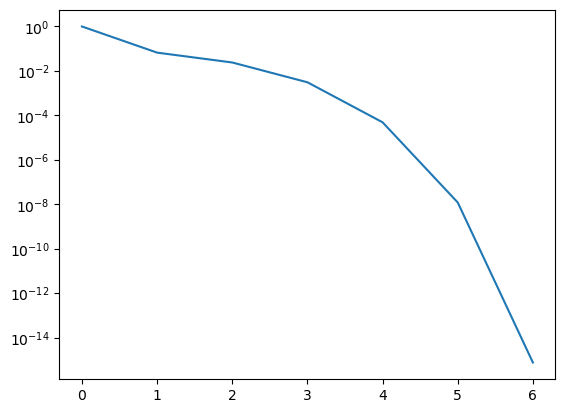

In [12]:
print("Newton found root",alpha,"in",iters_newton,"iterations.")
print("Residual on approximate solution is",abs(f(alpha)))
_=semilogy(errors_newton)

## Chord method

$$
q^{(k)} \equiv q = \frac{f(b)-f(a)}{b-a}
$$

$$
x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})}{q}
$$

In [13]:
def chord(f,a,b,x0,eps,n_max):
	'''
	Implementation of chord method.
	'''
	q = (f(b) - f(a))/(b-a)
	err = eps +1.
	errors = [err]
	it = 0
	x = x0
	while (err > eps and it < n_max):
		x_new = x - f(x)/q
		err = abs(x_new - x)
		errors.append(err)
		x = x_new
		it += 1
		
	return x, it, errors

Chords found root 0.9061798459469729 in 13 iterations.
Residual on approximate solution is 5.70847473767655e-11


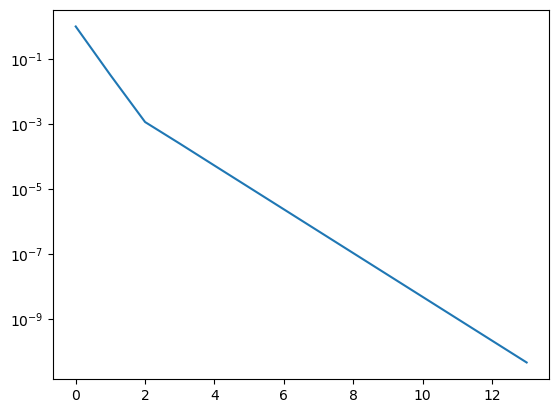

In [14]:
[alpha, iters_chord, errors_chords] = chord(f,a,b,x0,eps,n_max)
print("Chords found root",alpha,"in",iters_chord,"iterations.")
print("Residual on approximate solution is",abs(f(alpha)))
_=semilogy(errors_chords)

## Secant method

$$
q^{(k)} = \frac{f(x^{(k)})-f(x^{(k-1)})}{x^{(k)} - x^{(k-1)}}
$$

$$
x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})}{q^{(k)}}
$$

Note that this algorithm requires **two** initial points

In [15]:
def secant(f,x0,x00,eps,n_max):
    err = eps +1.
    errors = [err]
    it = 0
    xk = x0
    xkk = x00

    while (err > eps and it < n_max):
          qk = (f(xk) - f(xkk))/(xk - xkk)
          x_new = xk - f(xk)/qk
          err = abs(x_new - xk)
          xkk = xk
          xk = x_new
          errors.append(err)
          it += 1
    return xk, it, errors


Secant found root 0.906179845938664 in 7 iterations.
Residual on approximate solution is 0.0


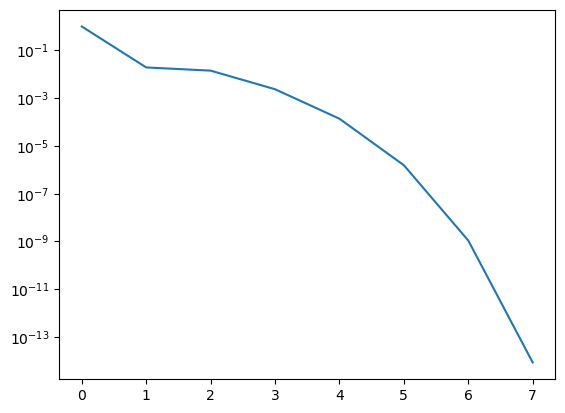

In [16]:
[alpha, iters_secant, errors_secant] = secant(f,x0,x00,eps,n_max)
print("Secant found root",alpha,"in",iters_secant,"iterations.")
print("Residual on approximate solution is",abs(f(alpha)))
_=semilogy(errors_secant)

## Fixed point iterations

The idea is to transform the problem $f(x) = 0$ into $x-\phi(x)=0$, where $\phi(\alpha)= \alpha \iff f(\alpha)=0$, so that we can use the _fixed point iteration_ 
$$ x^{(k+1)} = \phi(x^{(k)}).$$


We want to solve $f(t) = \dfrac{t}{8}\left(63 t^4 - 70 t^2 + 15\right) = 0$; we can focus our attention on the roots finding of $f_1 = 63 t^4 - 70 t^2 + 15$.

We recast $f_1(t)$ in terms of $t - \phi(t)$ in many ways:

- Dividing by $70t$: 
$$\dfrac{63}{70}t^3 - t + \dfrac{15}{70t} = 0 \implies \phi_1 = \dfrac{63}{70}t^3 + \dfrac{15}{70t}$$

- Dividing by $63t^3$:
$$t - \dfrac{70}{63t} + \dfrac{15}{63t^3} = 0 \implies \phi_2 = \dfrac{70}{63t} - \dfrac{15}{63t^3}$$

- Multiplying by $\dfrac{t}{15}$:
$$\dfrac{63}{15}t^5 - \dfrac{70}{15}t^3 + t  = 0 \implies \phi_3 = -\dfrac{63}{15}t^5 + \dfrac{70}{15}t^3$$

- Finally:
$$70t^2 = 63t^4 + 15 \implies t = \sqrt{\dfrac{63t^4 + 15}{70}} \implies \phi_4 = \sqrt{\dfrac{63t^4 + 15}{70}}$$

In [17]:
# phi = lambda x : 63./70.*x**3 + 15./(70.*x)
# phi_prime = lambda x : 63./70.*3*x**2 - 15./(70.*x**2)

# phi = lambda x : 70.0/(63.*x) - 15/(63*x**3)
# phi_prime = lambda x : -70./(63*x**2) + 15.*3./(63.*x**4)

phi = lambda x : 70.0/15.0*x**3 - 63.0/15.0*x**5
phi_prime = lambda x : 70./15.0*3*x**2 - 63.0/15.0*5*x**4

# phi = lambda x : sqrt((63.*x**4 + 15.0)/70.)
# phi_prime = lambda x : 1.0/(2.0*sqrt((63.*x**4 + 15.0)/70.))*(63.*4*x**3/70.)

Secant found root 4.444733555182444e-87 in 8 iterations.
Residual on approximate solution is 8.333875415967082e-87
phi_prime(alpha)= 2.765791892719068e-172


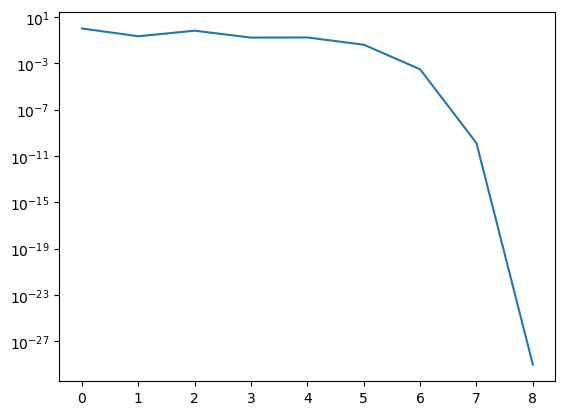

In [18]:
def fixed_point(phi,x0,eps,n_max):
	x = x0
	err = eps + 1.
	errors = [err]
	it = 0
	while (err > eps and it < n_max):
		x_new = phi(x)
		err = abs (x_new - x)
		x = x_new
		it +=1
		errors.append(err)

	return x, it, errors

[alpha, iters_fixed, errors_fixed] = fixed_point(phi,0.8,eps,n_max)
print("Secant found root",alpha,"in",iters_fixed,"iterations.")
print("Residual on approximate solution is",abs(f(alpha)))
_=semilogy(errors_fixed)

print("phi_prime(alpha)=",phi_prime(alpha))

## Comparison

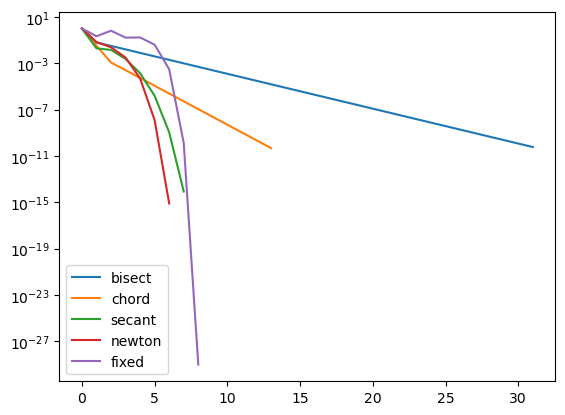

In [19]:
# plot the error convergence for the methods
semilogy(errors_bisect, label='bisect')
semilogy(errors_chords, label='chord')
semilogy(errors_secant, label='secant')
semilogy(errors_newton, label ='newton')
semilogy(errors_fixed, label ='fixed')
_ = legend()

## On the convergence of the Newton method
We know, and have numerically confirmed, that the convergence rate of the Newton method is quadratic, at least in some **_good_** situations. 
In particular the convergence of Newton method becomes linear when we are seeking zeroes with multiplicity higher than 1.

As a simple example let us consider the following polynomial: 
$$ f(x) = x^2(x^3-1).$$
As a real function of real variable, this polynomial has one simple root at $1$ and a double root at $0$. 

In [20]:
t = sym.symbols('t')
f_sym = t**2*(t**3-1) 
f_prime_sym = sym.diff(f_sym,t)
f = sym.lambdify(t, f_sym, 'numpy')
f_prime = sym.lambdify(t,f_prime_sym, 'numpy')

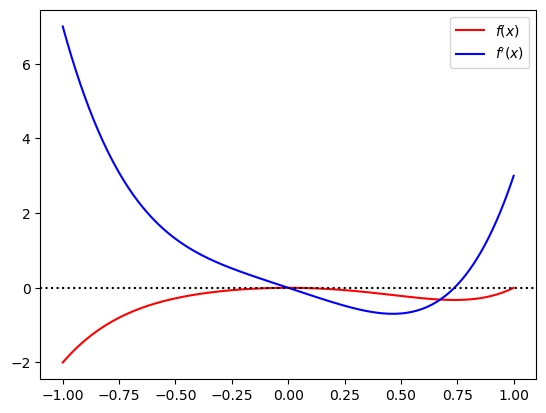

In [21]:
plot(x,f(x),label="$f(x)$",color="r")
plot(x,f_prime(x),label="$f'(x)$",color="b")
axhline(0,color="black",linestyle="dotted")
_=legend()

Secant found root -6.553090510722184e-11 in 76 iterations.
Residual on approximate solution is 4.294299524171714e-21


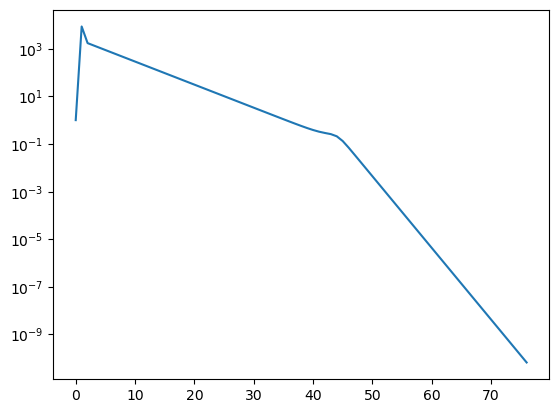

In [22]:
[alpha, iters_newton, errors_newton] = newton(f,f_prime,0.7368,eps,n_max)
print("Secant found root",alpha,"in",iters_newton,"iterations.")
print("Residual on approximate solution is",abs(f(alpha)))
_=semilogy(errors_newton)